In [1]:
%cd ..

/nfs/scistore16/edelgrp/fzimin/depth-poset


/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import inspect

import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh
import pickle as pkl

from src.depth import DepthPoset

import itertools

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import lines as mlines

from src.depth import DepthPoset


from tqdm import tqdm
from src.profiling import Timer


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/ipykern

AttributeError: _ARRAY_API not found

# Load and Format the Data

## Define Directories

In [3]:
# the directory to save pictures
path_to_save = 'raports/pics/torus-transpositions'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

In [4]:
# the directory to load transpositions data
directory = "results/transpositions-during-linear-homotopy-between-barycentric-cubical-toruses"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

## Check sizes of files

In [5]:
def get_dim_and_n_from_torus_file(path):
    with open(path, 'rb') as file:
        res = pkl.load(file)
    return res['dim'], res['n']

/tmp/ipykernel_1628931/4026766541.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses/{path}.pkl')
Extracting the Dimensions and sizes of toruses: 100%|██████████| 1529/1529 [00:01<00:00, 1256.94it/s]


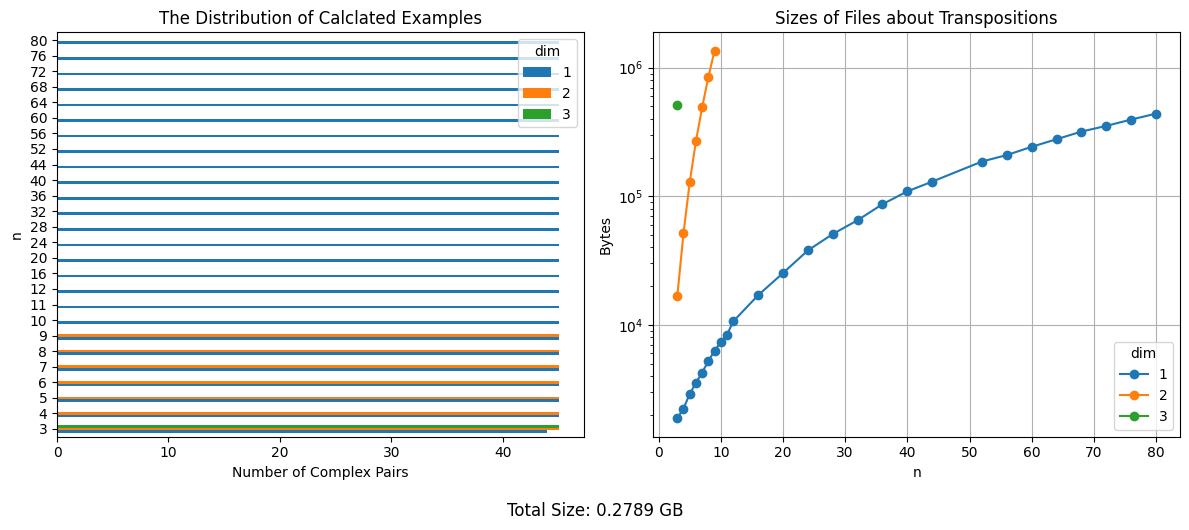

In [6]:
df_sizes = pd.DataFrame({'path': paths})
df_sizes['size'] = df_sizes['path'].apply(lambda path: os.path.getsize(path))
df_sizes['original_path0'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[0])
df_sizes['original_path1'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[1])
df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses/{path}.pkl')
df_sizes['original_size0'] = df_sizes['original_path0'].apply(lambda path: os.path.getsize(path))
df_sizes['original_size1'] = df_sizes['original_path1'].apply(lambda path: os.path.getsize(path))
tqdm.pandas(desc='Extracting the Dimensions and sizes of toruses')
df_sizes['dim&n'] = df_sizes['original_path0'].progress_apply(lambda path: get_dim_and_n_from_torus_file(path))
df_sizes['dim'] = df_sizes['dim&n'].apply(lambda dimn: dimn[0])
df_sizes['n'] = df_sizes['dim&n'].apply(lambda dimn: dimn[1])
df_sizes = df_sizes.drop(columns='dim&n')


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_title('The Distribution of Calclated Examples')
df_sizes.groupby(['dim', 'n'])['path'].count().reset_index().pivot_table(columns='dim', index='n', values='path').fillna(0).astype(int).plot(kind='barh', ax=axs[0])
axs[0].set_xlabel('Number of Complex Pairs')

axs[1].set_title('Sizes of Files about Transpositions')
df_sizes.groupby(['dim', 'n'])['size'].mean().reset_index().pivot_table(columns='dim', index='n', values='size').plot(logy=True, marker='o', ax=axs[1])
axs[1].set_ylabel('Bytes')
axs[1].grid(True)

fig.text(0.5, -0.05, f"Total Size: {df_sizes['size'].sum()*1024**-3:.4f} GB", ha='center', va='bottom', fontsize='large')
plt.tight_layout()
plt.show()

## Load Transpositions Data

In [7]:
df = []
errs = {}
for path in tqdm(paths):
    if os.path.getsize(path) < np.inf*1024**2:
        try:
            with open(path, 'rb') as file:
                loaded_dict = pkl.load(file)
            loaded_dict['transpositions'].insert(0, 'complex_index0', loaded_dict['complex_index0'])
            loaded_dict['transpositions'].insert(1, 'complex_index1', loaded_dict['complex_index1'])
            loaded_dict['transpositions'].insert(2, 'complex_dim', loaded_dict['complex_dim'])
            loaded_dict['transpositions'].insert(3, 'complex_shape', [loaded_dict['complex_shape']]*len(loaded_dict['transpositions']))
            df.append(loaded_dict['transpositions'])

        except Exception as err:
            errs.update({path: err})
    else:
        errs.update({path: 'Giant file'})
errs = pd.Series(errs)
if len(errs) > 0:
    errs_count = errs.astype(str).value_counts()
    print(f'There is some amount of errors:\n{errs_count.to_string(name=False)}\n')
    #for path in errs.index:
    #    if os.path.exists(path):
    #        os.remove(path)
    
df = pd.concat(df)

if not 'complex_n' in df.columns: 
    df.insert(3, 'complex_n', df['complex_shape'].apply(lambda x: x[0] if (np.array(x)[1:] == np.array(x)[:-1]).all() else None))

#print(f'There are {pd.isna(df['transposition']).sum()} empty transposition values in {len(df)} lines')
#df = df[~pd.isna(df['transposition'])]
#df = df.join(df['transposition'].apply(lambda tr: tr.to_dict()).apply(pd.Series))

print(f'df.shape = {df.shape}')
df.head()

100%|██████████| 1529/1529 [00:02<00:00, 578.34it/s]


df.shape = (2155923, 24)


,complex_index0,complex_index1,complex_dim,complex_n,complex_shape,time,value,birth_relation_cell_similarity,birth_relation_index_similarity,death_relation_cell_similarity,...,poset_node_index_similarity,relation_cell_similarity,relation_index_similarity,index 0,index 1,cell 0,cell 1,dim,type,switch
0,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.001931,0.431932,1.0,1.0,1.0,...,0.2,1.0,1.0,1,2,"((0,),)","((2,),)",0,birth-birth,no switch
1,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.022655,0.430177,1.0,1.0,1.0,...,1.0,1.0,1.0,0,1,"((1,),)","((2,),)",0,birth-unpaired,undefined
2,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.429125,1.571011,0.0,0.0,1.0,...,0.2,0.0,0.0,5,6,"((0,), (1,))","((3,), (0,))",1,death-death,no switch
3,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.719007,1.746056,0.0,1.0,0.0,...,1.0,0.0,1.0,6,7,"((0,), (1,))","((2,), (3,))",1,death-unpaired,undefined
4,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.856378,0.898951,0.0,1.0,0.0,...,1.0,0.0,1.0,2,3,"((0,),)","((3,),)",0,birth-birth,switch backward


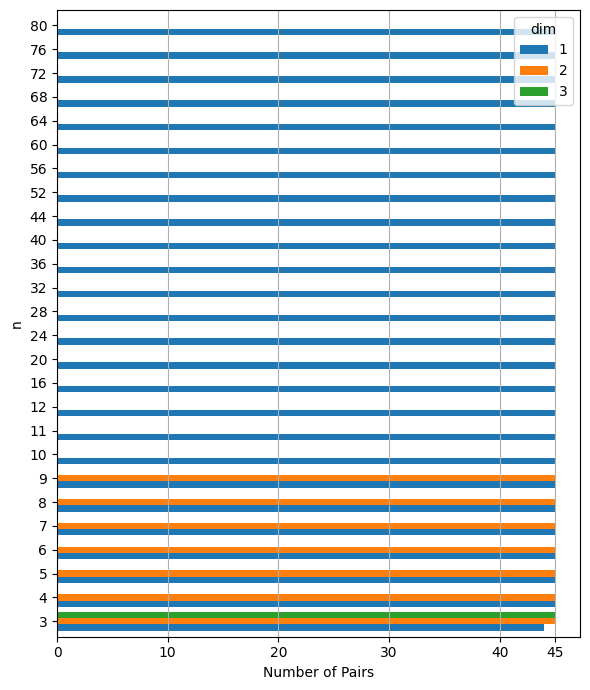

In [8]:
fig, ax = plt.subplots(figsize=(6, 7))

df_to_plot = df.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n'])['index 0'].count().reset_index().groupby(['complex_dim', 'complex_n']
            )['complex_index0'].count().reset_index().rename(columns=lambda s: s.replace('complex_', '')).pivot_table(columns='dim', index='n', values='index0').fillna(0).astype(int)
df_to_plot.plot(kind='barh', width=0.8, ax=ax)

ax.set_xlabel('Number of Pairs')

xticks = ax.get_xticks()
xticks = np.unique(np.append(xticks[xticks <= df_to_plot.max().max()], df_to_plot.max().max())).astype(int)

ax.set_xticks(xticks)

ax.grid(axis='x')

plt.tight_layout()

plt.savefig(os.path.join(path_to_save, 'distribution.png'))

# Switch Types Distribution

In [9]:
tqdm.pandas(desc="Define switch type from type and switch columns")
df['switch type'] = df.progress_apply(lambda row: row['type'] if row['switch'] in ['switch', 'switch backward', 'switch forward'] else row['switch'], axis=1)

df['switch type'].value_counts()

Define switch type from type and switch columns: 100%|██████████| 2155923/2155923 [00:24<00:00, 89154.94it/s] 


switch type
no switch      2024184
undefined        50398
death-death      37207
birth-birth      37102
birth-death       7032
Name: count, dtype: int64

In [10]:
# define colors
switch_type_colors = {
    'birth-birth': '#1f77b4',    # синий — начало и начало, что-то "созидательное"
    'birth-death': '#2ca02c',    # зелёный — жизнь и смерть, естественный переход
    'death-death': '#d62728',    # красный — смерть и смерть, ассоциируется с концом
    'no switch': '#9467bd',      # фиолетовый — устойчивость, "застывшее" состояние
    'undefined': '#7f7f7f'       # серый — неопределённость
}
switch_type_colors = pd.Series(switch_type_colors)

switch_type_colors

birth-birth    #1f77b4
birth-death    #2ca02c
death-death    #d62728
no switch      #9467bd
undefined      #7f7f7f
dtype: object

In [11]:
df_switch_types = df.copy()

with Timer() as timer:
    df_switch_types = df_switch_types.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n', 'dim', 'switch type'])['index 0'].count().reset_index().rename(columns={'index 0': 'count'})
    print(f'Calculated counts-values for each type in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()
    
    df_switch_types_mean = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].mean().reset_index()
    df_switch_types_mean = df_switch_types_mean.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')
    df_switch_types_mean.index.name = 'n'
    print(f'Calculated mean count in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()
    

    df_switch_types_std = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].std().reset_index()
    df_switch_types_std = df_switch_types_std.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')
    df_switch_types_std.index.name = 'n'
    print(f'Calculated variation count in {timer.elapsed():.4f} seconds.')

df_switch_types_mean = df_switch_types_mean.sort_index(axis=1)
df_switch_types_std = df_switch_types_std.sort_index(axis=1)

complex_dims = pd.unique(df['complex_dim'])
transposition_dims = pd.unique(df['dim'])

print()
print(f'df_switch_types_std.shape = {df_switch_types_std.shape}')
print('...\n')
print(f'df_switch_types_mean.shape = {df_switch_types_mean.shape}')
df_switch_types_mean.head()


Calculated counts-values for each type in 0.5919 seconds.
Calculated mean count in 0.0083 seconds.
Calculated variation count in 0.0068 seconds.

df_switch_types_std.shape = (26, 33)
...

df_switch_types_mean.shape = (26, 33)


complex_dim           1                                                      \
dim                   0                               1                       
switch type birth-birth no switch undefined death-death no switch undefined   
n                                                                             
3              1.000000  1.000000  1.000000    1.000000  1.071429  1.193548   
4              1.055556  1.718750  1.047619    1.117647  2.135135  1.424242   
5              1.281250  3.159091  1.282051    1.281250  3.325581  1.305556   
6              1.944444  5.227273  1.555556    1.685714  4.977273  1.285714   
7              2.113636  7.133333  1.531250    1.738095  7.200000  1.837838   

complex_dim           2                                    ...            3  \
dim                   0                                 1  ...            1   
switch type birth-birth   no switch undefined birth-birth  ...    no switch   
n                                                          ...                
3              2.302326   14.866667  1.627907    4.068182  ...  1388.644444   
4              5.688889   53.511111  1.837209    9.000000  ...          NaN   
5              9.377778  140.488889  2.121951   15.066667  ...          NaN   
6             14.155556  303.800000  2.340909   25.755556  ...          NaN   
7             18.177778  558.200000  2.666667   40.000000  ...          NaN   

complex_dim                                                             \
dim                             2                                        
switch type undefined birth-birth birth-death death-death    no switch   
n                                                                        
3               132.0   22.955556   13.622222   68.866667  1402.222222   
4                 NaN         NaN         NaN         NaN          NaN   
5                 NaN         NaN         NaN         NaN          NaN   
6                 NaN         NaN         NaN         NaN          NaN   
7                 NaN         NaN         NaN         NaN          NaN   

complex_dim                                                
dim                               3                        
switch type   undefined death-death   no switch undefined  
n                                                          
3            138.088889   10.022222  163.155556  2.348837  
4                   NaN         NaN         NaN       NaN  
5                   NaN         NaN         NaN       NaN  
6                   NaN         NaN         NaN       NaN  
7                   NaN         NaN         NaN       NaN  

[5 rows x 33 columns]

Ploting: 100%|██████████| 12/12 [00:00<00:00, 54.65it/s]


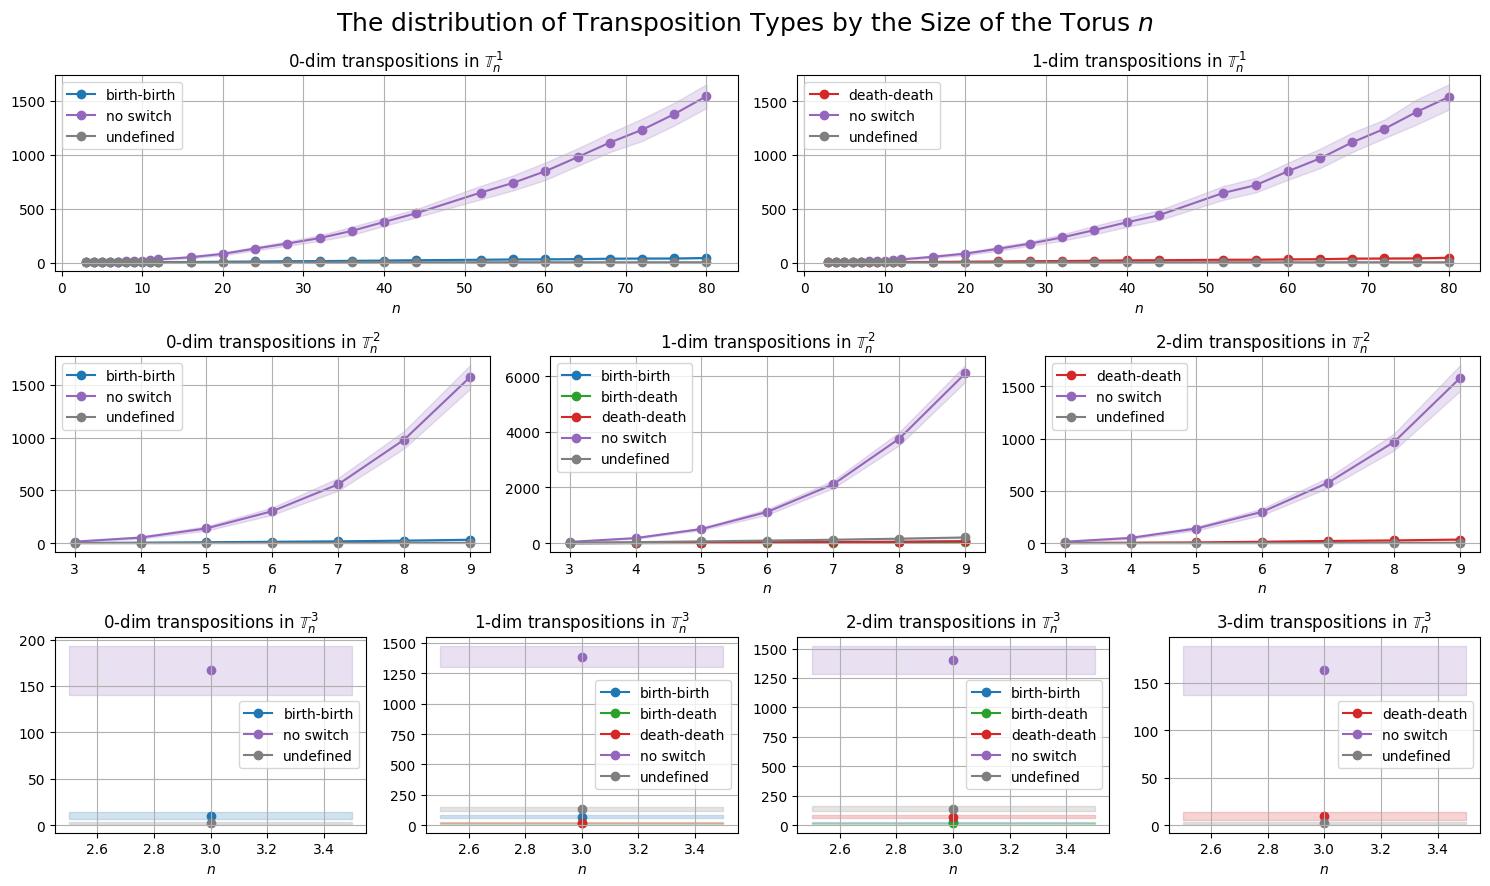

In [12]:
fig = plt.figure(figsize=(15, 9))
fig.suptitle('The distribution of Transposition Types by the Size of the Torus $n$', fontsize=18)

rows = len(complex_dims)
cols = 12
gs = gridspec.GridSpec(rows, cols, figure=fig)

axs = []
for i in range(len(complex_dims)):
    axs.append([])
    for j in range(i + 2):
        start = cols*j//(i+2)
        end = cols*(j + 1)//(i+2)
        ax = fig.add_subplot(gs[i, start:end])
        axs[-1].append(ax)

for (i, complex_dim), (j, transposition_dim) in tqdm(itertools.product(enumerate(complex_dims), enumerate(transposition_dims)), 
                                                     total=len(complex_dims)*len(transposition_dims), desc='Ploting'):
    if j <= i + 1:
        df_mean_to_plot = df_switch_types_mean[complex_dim][transposition_dim]
        df_std_to_plot = df_switch_types_std[complex_dim][transposition_dim]
        
        df_mean_to_plot = df_mean_to_plot.dropna(how='all')
        df_std_to_plot = df_std_to_plot.dropna(how='all')

        assert (df_mean_to_plot.columns == df_std_to_plot.columns).all()
        assert len(df_mean_to_plot) == len(df_std_to_plot)

        for col in df_mean_to_plot.columns:
            axs[i][j].plot(df_mean_to_plot[col], linestyle='-', marker='o', zorder=1, label=col, color=switch_type_colors[col])
            x = (df_mean_to_plot.index).values
            y0 = (df_mean_to_plot[col] - df_std_to_plot[col]).values
            y1 = (df_mean_to_plot[col] + df_std_to_plot[col]).values
            if len(x) == 1:
                eps = 0.5
                x = [x[0] - eps, x[0] + eps]
                y0 = y0[0]*np.ones(2)
                y1 = y1[0]*np.ones(2)
            axs[i][j].fill_between(x, y0, y1, alpha=0.2, zorder=0, color=switch_type_colors[col])

        axs[i][j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}_n$')
        axs[i][j].grid(True)
        axs[i][j].legend()
        axs[i][j].set_xlabel('$n$')
plt.tight_layout()
plt.savefig(os.path.join(path_to_save, 'switch-types.png'))

Ploting: 100%|██████████| 12/12 [00:00<00:00, 123.97it/s]


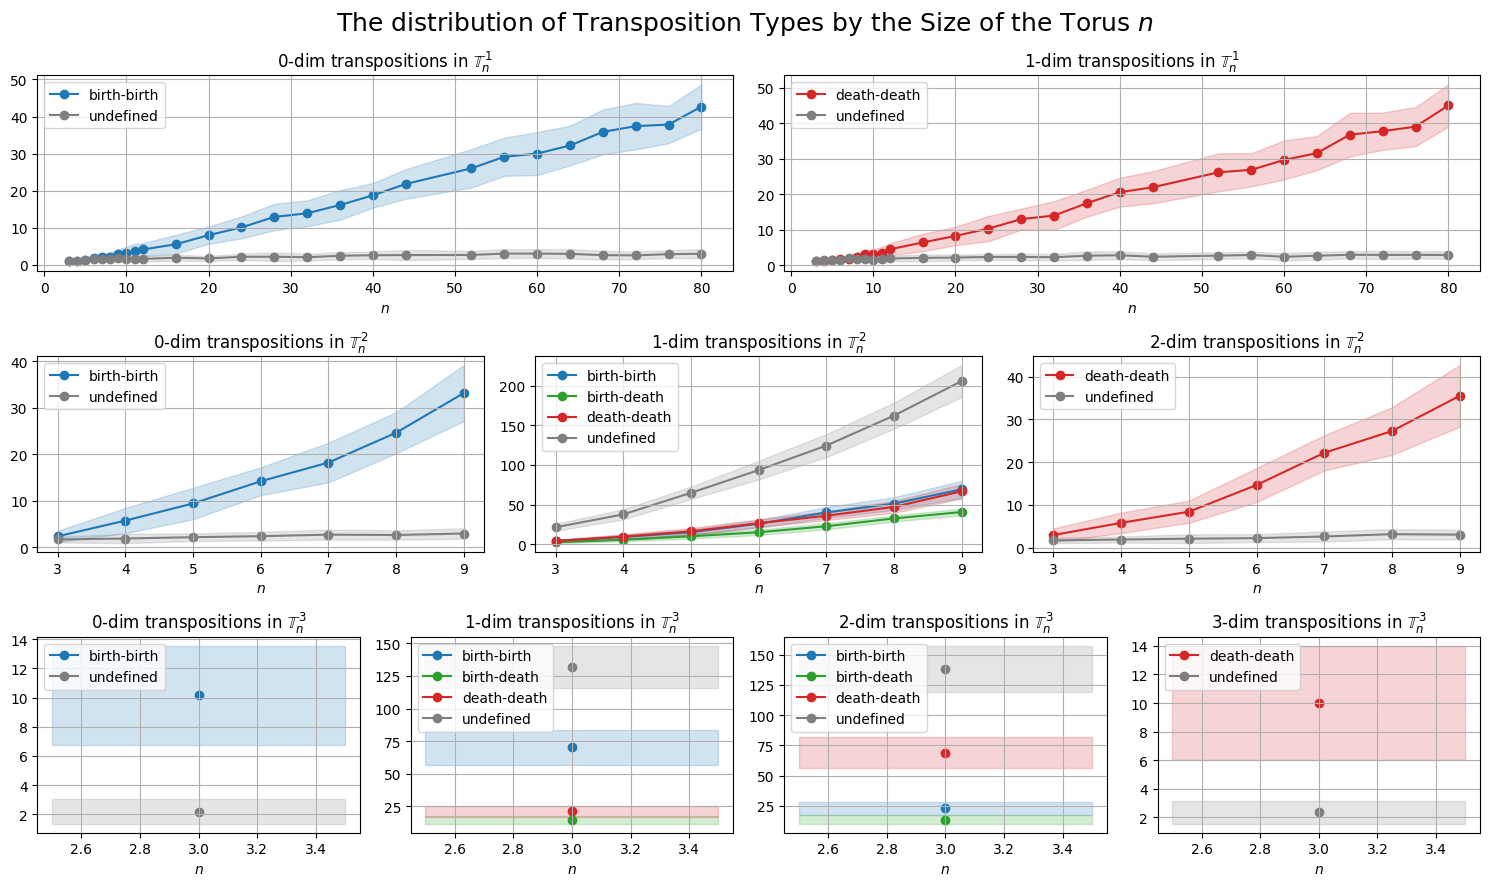

In [13]:
fig = plt.figure(figsize=(15, 9))
fig.suptitle('The distribution of Transposition Types by the Size of the Torus $n$', fontsize=18)

rows = len(complex_dims)
cols = 12
gs = gridspec.GridSpec(rows, cols, figure=fig)

axs = []
for i in range(len(complex_dims)):
    axs.append([])
    for j in range(i + 2):
        start = cols*j//(i+2)
        end = cols*(j + 1)//(i+2)
        ax = fig.add_subplot(gs[i, start:end])
        axs[-1].append(ax)

for (i, complex_dim), (j, transposition_dim) in tqdm(itertools.product(enumerate(complex_dims), enumerate(transposition_dims)), 
                                                     total=len(complex_dims)*len(transposition_dims), desc='Ploting'):
    if j <= i + 1:
        df_mean_to_plot = df_switch_types_mean[complex_dim][transposition_dim]
        df_std_to_plot = df_switch_types_std[complex_dim][transposition_dim]
        
        df_mean_to_plot = df_mean_to_plot.dropna(how='all')
        df_std_to_plot = df_std_to_plot.dropna(how='all')

        assert (df_mean_to_plot.columns == df_std_to_plot.columns).all()
        assert len(df_mean_to_plot) == len(df_std_to_plot)

        for col in df_mean_to_plot.columns[df_mean_to_plot.columns != 'no switch']:
            axs[i][j].plot(df_mean_to_plot[col], linestyle='-', marker='o', zorder=1, label=col, color=switch_type_colors[col])
            x = (df_mean_to_plot.index).values
            y0 = (df_mean_to_plot[col] - df_std_to_plot[col]).values
            y1 = (df_mean_to_plot[col] + df_std_to_plot[col]).values
            if len(x) == 1:
                eps = 0.5
                x = [x[0] - eps, x[0] + eps]
                y0 = y0[0]*np.ones(2)
                y1 = y1[0]*np.ones(2)
            axs[i][j].fill_between(x, y0, y1, alpha=0.2, zorder=0, color=switch_type_colors[col])

        axs[i][j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}_n$')
        axs[i][j].grid(True)
        axs[i][j].legend(loc='upper left')
        axs[i][j].set_xlabel('$n$')
plt.tight_layout()
plt.savefig(os.path.join(path_to_save, 'switch-types (without no switch).png'))

# The Changes of Depth Posets

In [14]:
from src import depth_poset_similarity_scores

In [15]:
similarity_scores = [name for name, func in inspect.getmembers(depth_poset_similarity_scores, inspect.isfunction) 
                     if func.__module__ == depth_poset_similarity_scores.__name__]

In [16]:
df_similarities_mean = df.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])[similarity_scores].mean()
df_similarities_mean = df_similarities_mean.reset_index()
df_similarities_mean = df_similarities_mean.melt(id_vars=['complex_dim', 'complex_n', 'dim', 'switch type'], value_vars=similarity_scores, var_name='score', value_name='value')
df_similarities_mean = df_similarities_mean.pivot_table(index='complex_n', columns=['score', 'complex_dim', 'dim', 'switch type'], values='value')

print(f'df_similarities_mean.shape = {df_similarities_mean.shape}')
df_similarities_mean.head(10)

df_similarities_mean.shape = (26, 330)


score       birth_relation_cell_similarity                                  \
complex_dim                              1                                   
dim                                      0                               1   
switch type                    birth-birth no switch undefined death-death   
complex_n                                                                    
3                                 0.000000       1.0  0.416667    0.000000   
4                                 0.000000       1.0  0.590909    0.000000   
5                                 0.034146       1.0  0.313333    0.097561   
6                                 0.121973       1.0  0.394345    0.097094   
7                                 0.181430       1.0  0.393878    0.196722   
8                                 0.263597       1.0  0.462022    0.306437   
9                                 0.318193       1.0  0.467221    0.353985   
10                                0.340374       1.0  0.527214    0.409291   
11                                0.416795       1.0  0.547476    0.451827   
12                                0.443387       1.0  0.547164    0.480249   

score                                                                        \
complex_dim                               2                                   
dim                                       0                               1   
switch type no switch undefined birth-birth no switch undefined birth-birth   
complex_n                                                                     
3            0.333333  0.594595    0.579177       1.0  0.695100    0.510435   
4            0.662447  0.539007    0.725146       1.0  0.792271    0.676649   
5            0.791375  0.547518    0.787564       1.0  0.821651    0.784500   
6            0.822907  0.540000    0.845401       1.0  0.849583    0.825473   
7            0.920113  0.482260    0.888347       1.0  0.884396    0.865572   
8            0.934209  0.504099    0.909460       1.0  0.897302    0.897043   
9            0.932922  0.466963    0.929751       1.0  0.923017    0.913201   
10           0.959260  0.578770         NaN       NaN       NaN         NaN   
11           0.965511  0.517581         NaN       NaN       NaN         NaN   
12           0.968608  0.621723         NaN       NaN       NaN         NaN   

score        ... relation_index_similarity                                    \
complex_dim  ...                         3                                     
dim          ...                         1                     2               
switch type  ...                 no switch undefined birth-birth birth-death   
complex_n    ...                                                               
3            ...                  0.911506  0.962281    0.985893    0.966482   
4            ...                       NaN       NaN         NaN         NaN   
5            ...                       NaN       NaN         NaN         NaN   
6            ...                       NaN       NaN         NaN         NaN   
7            ...                       NaN       NaN         NaN         NaN   
8            ...                       NaN       NaN         NaN         NaN   
9            ...                       NaN       NaN         NaN         NaN   
10           ...                       NaN       NaN         NaN         NaN   
11           ...                       NaN       NaN         NaN         NaN   
12           ...                       NaN       NaN         NaN         NaN   

score                                                                        
complex_dim                                                                  
dim                                                   3                      
switch type death-death no switch undefined death-death no switch undefined  
complex_n                                                                    
3              0.955208  0.911243  0.961703    0.982

In [17]:
df_similarities_std = df.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])[similarity_scores].std()
df_similarities_std = df_similarities_std.reset_index()
df_similarities_std = df_similarities_std.melt(id_vars=['complex_dim', 'complex_n', 'dim', 'switch type'], value_vars=similarity_scores, var_name='score', value_name='value')
df_similarities_std = df_similarities_std.pivot_table(index='complex_n', columns=['score', 'complex_dim', 'dim', 'switch type'], values='value')

print(f'df_similarities_std.shape = {df_similarities_std.shape}')
df_similarities_std.head(10)

df_similarities_std.shape = (26, 330)


score       birth_relation_cell_similarity                                  \
complex_dim                              1                                   
dim                                      0                               1   
switch type                    birth-birth no switch undefined death-death   
complex_n                                                                    
3                                 0.000000       0.0  0.503610    0.000000   
4                                 0.000000       0.0  0.503236    0.000000   
5                                 0.095594       0.0  0.399319    0.158883   
6                                 0.144418       0.0  0.342853    0.171539   
7                                 0.160877       0.0  0.242782    0.184147   
8                                 0.184750       0.0  0.294646    0.214542   
9                                 0.161357       0.0  0.201237    0.217754   
10                                0.170897       0.0  0.225758    0.204629   
11                                0.168363       0.0  0.234704    0.210658   
12                                0.168799       0.0  0.192865    0.209645   

score                                                                        \
complex_dim                               2                                   
dim                                       0                               1   
switch type no switch undefined birth-birth no switch undefined birth-birth   
complex_n                                                                     
3            0.479463  0.497743    0.173004       0.0  0.142607    0.162481   
4            0.452104  0.499048    0.128253       0.0  0.107499    0.122694   
5            0.332433  0.473233    0.118500       0.0  0.083183    0.101524   
6            0.287962  0.387924    0.092836       0.0  0.064686    0.080058   
7            0.151932  0.343855    0.072920       0.0  0.062893    0.063961   
8            0.134659  0.314862    0.063407       0.0  0.050966    0.053438   
9            0.123243  0.251086    0.051145       0.0  0.035541    0.045075   
10           0.095722  0.292208         NaN       NaN       NaN         NaN   
11           0.080845  0.231023         NaN       NaN       NaN         NaN   
12           0.076989  0.242214         NaN       NaN       NaN         NaN   

score        ... relation_index_similarity                                    \
complex_dim  ...                         3                                     
dim          ...                         1                     2               
switch type  ...                 no switch undefined birth-birth birth-death   
complex_n    ...                                                               
3            ...                  0.049372  0.039362    0.012359    0.018066   
4            ...                       NaN       NaN         NaN         NaN   
5            ...                       NaN       NaN         NaN         NaN   
6            ...                       NaN       NaN         NaN         NaN   
7            ...                       NaN       NaN         NaN         NaN   
8            ...                       NaN       NaN         NaN         NaN   
9            ...                       NaN       NaN         NaN         NaN   
10           ...                       NaN       NaN         NaN         NaN   
11           ...                       NaN       NaN         NaN         NaN   
12           ...                       NaN       NaN         NaN         NaN   

score                                                                        
complex_dim                                                                  
dim                                                   3                      
switch type death-death no switch undefined death-death no switch undefined  
complex_n                                                                    
3              0.027578  0.049773  0.040642    0.015

Ploting similarity scores fully:   0%|          | 0/10 [00:00<?, ?it/s]

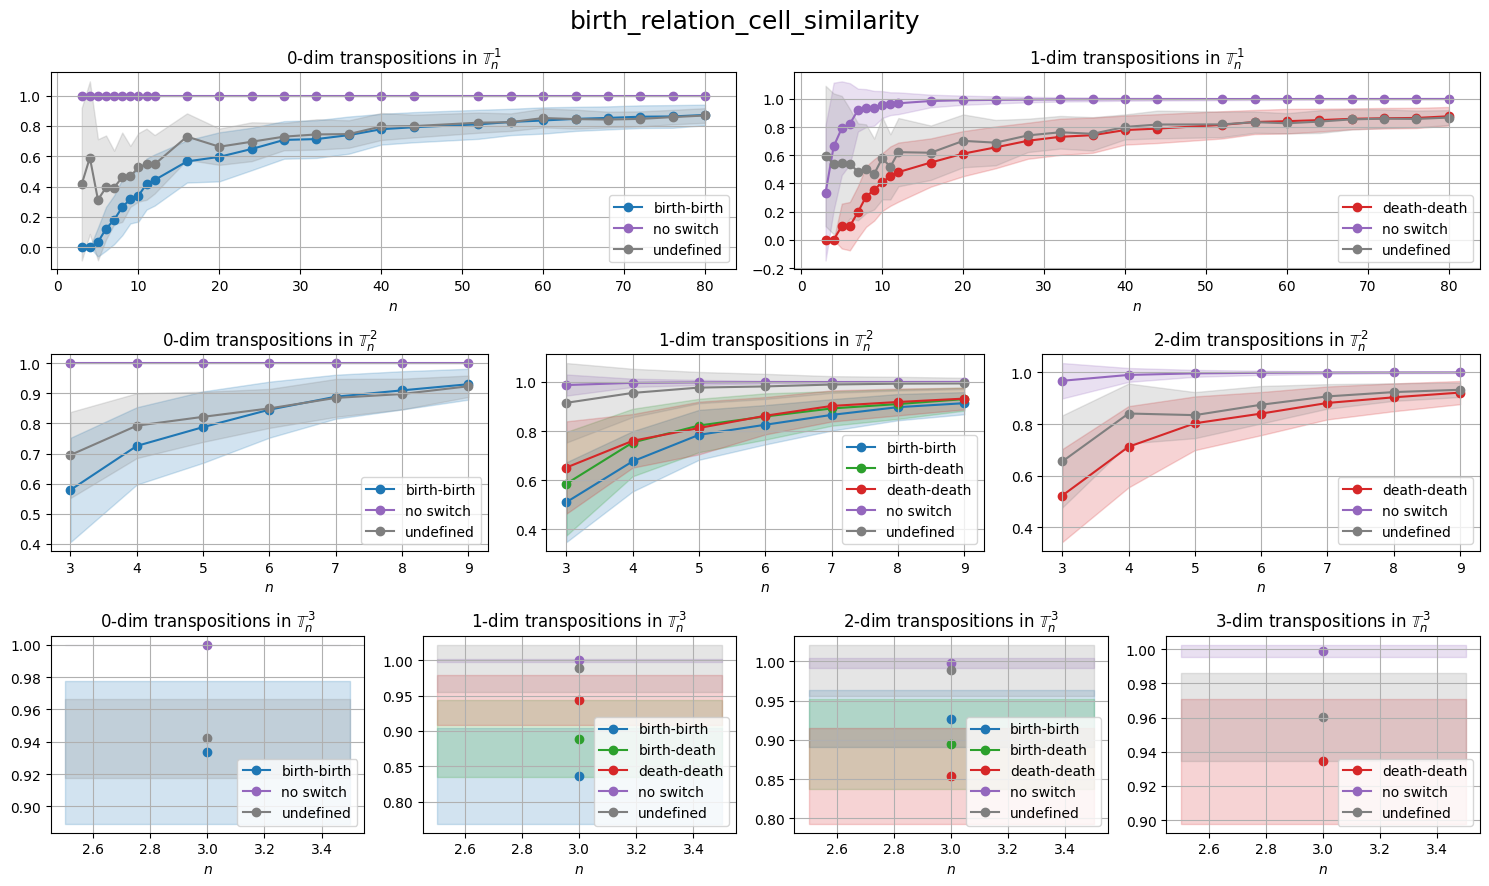

Ploting similarity scores fully: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


In [18]:
path_temmplate_similarities = 'raports/pics/torus-transpositions/similaritites/score={score}.png'
if not os.path.exists(path_temmplate_similarities[:path_temmplate_similarities.rfind('/')]):
    os.makedirs(path_temmplate_similarities[:path_temmplate_similarities.rfind('/')])

for iteration, score in tqdm(enumerate(similarity_scores), total=len(similarity_scores), desc='Ploting similarity scores fully'):
    df_score_mean = df_similarities_mean[score]
    df_score_std = df_similarities_std[score]

    fig = plt.figure(figsize=(15, 9))
    fig.suptitle(score, fontsize=18)

    rows = len(complex_dims)
    cols = 12
    gs = gridspec.GridSpec(rows, cols, figure=fig)

    axs = []
    for i in range(len(complex_dims)):
        axs.append([])
        for j in range(i + 2):
            start = cols*j//(i+2)
            end = cols*(j + 1)//(i+2)
            ax = fig.add_subplot(gs[i, start:end])
            axs[-1].append(ax)
    
    for (i, complex_dim), (j, transposition_dim) in itertools.product(enumerate(complex_dims), enumerate(transposition_dims)):
        if j <= i + 1:
            df_mean_to_plot = df_score_mean[complex_dim][transposition_dim]
            df_std_to_plot = df_score_std[complex_dim][transposition_dim]
            
            df_mean_to_plot = df_mean_to_plot.dropna(how='all')
            df_std_to_plot = df_std_to_plot.dropna(how='all')

            assert (df_mean_to_plot.columns == df_std_to_plot.columns).all()
            assert len(df_mean_to_plot) == len(df_std_to_plot)

            for col in df_mean_to_plot.columns:
                axs[i][j].plot(df_mean_to_plot[col], linestyle='-', marker='o', zorder=1, label=col, color=switch_type_colors[col])
                x = (df_mean_to_plot.index).values
                y0 = (df_mean_to_plot[col] - df_std_to_plot[col]).values
                y1 = (df_mean_to_plot[col] + df_std_to_plot[col]).values
                if len(x) == 1:
                    eps = 0.5
                    x = [x[0] - eps, x[0] + eps]
                    y0 = y0[0]*np.ones(2)
                    y1 = y1[0]*np.ones(2)
                axs[i][j].fill_between(x, y0, y1, alpha=0.2, zorder=0, color=switch_type_colors[col])

            axs[i][j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}_n$')
            axs[i][j].grid(True)
            axs[i][j].legend(loc='lower right')
            axs[i][j].set_xlabel('$n$')
    
    plt.tight_layout()

    path = path_temmplate_similarities.format(score=score).replace('_', '-')
    plt.savefig(path)
    if iteration == 0:
        plt.show()
    plt.close()

# Raporting

In [19]:
s_item = r"""
\item \textbf{{{score_name}}} - {score_desc}
We can see the values of this score applying to depth posets before and after transpositions of different types for barycentric cubical tori dimension $d$ and size $n$ in Figure \ref{{fig:{score_ref}}}
""".strip()

s_figure = r"""
\begin{{figure}}[h!]
    \hspace*{{-3cm}}
    \centering
    \includegraphics[width=1.5\textwidth]{{{score_path}}}
    \caption{{{score_name} values}}
    \label{{fig:{score_ref}}}
\end{{figure}}
""".strip()

In [20]:
score_names = [score.replace('_', r'\_') for score in similarity_scores]
score_descs = [getattr(depth_poset_similarity_scores, score).__doc__.strip() for score in similarity_scores]
score_refs = [score.replace('_', '-') for score in similarity_scores]
score_paths = [path_temmplate_similarities.format(score=score).replace('_', '-').replace('raports/', '') for score in similarity_scores]

In [21]:
s_scores_items = '\n'.join([s_item.format(score_name=score_name, score_desc=score_desc, score_ref=score_ref) for score_name, score_desc, score_ref in zip(score_names, score_descs, score_refs)])
s_scores_figs = '\n'.join([s_figure.format(score_name=score_name, score_path=score_path, score_ref=score_ref) for score_name, score_path, score_ref in zip(score_names, score_paths, score_refs)])
s_scores = f"""
\\par We have {len(similarity_scores)} scores to measure the similarity of 2 depth posets: 
\\begin{{itemize}}
{s_scores_items}
\\end{{itemize}}
%\\par We used these scores to measure the similarity of depth poset before and after the transpositions, and we can see the result in coresponding Figures.
{s_scores_figs}
"""

In [22]:
# load texts, describing the process
with open('texts/barycentric-cubical-torus-transpositions - descr.txt', 'r') as file:
    s_descr = file.read()

with open('texts/barycentric-cubical-torus-transpositions - transpositions.txt', 'r') as file:
    s_trans = file.read()


# load LaTeX template
with open('texts/template.tex', 'r') as file:
    s_latex = file.read()

In [23]:
body = f"""
\\section{{Description}}
{s_descr}

\\section{{Transpositions}}
{s_trans}

\\section{{Similarity Scores}}
{s_scores}

""".strip()

raport = s_latex.replace('BODY', body)
print(raport)

\documentclass{article}
\usepackage{amsfonts} 
\usepackage{amsmath}
\usepackage{hyperref}
\usepackage{graphicx}
\usepackage{subcaption}
\usepackage{booktabs}
\usepackage{makecell}
\usepackage{multirow}
%\usepackage{placeins}

\begin{document}

\section{Description}
\par The first we just calculated several Barycentric Cubical Tori. The distribution of calculated toruses we can see in the Figure \ref{fig:cases_distribution}.
\begin{figure}[htbp]
    \centering
    \begin{subfigure}[t]{0.45\textwidth}
        \centering
        \includegraphics[width=\textwidth]{pics/torus scores/cases.png}
        \caption{Barycentric Cubical Tori}
        \label{fig:cases_distribution}
    \end{subfigure}
    \hfill
    \begin{subfigure}[t]{0.45\textwidth}
        \centering
        \includegraphics[width=\textwidth]{pics/torus-transpositions/distribution.png}
        \caption{Calculated pairs}
        \label{fig:pairs_distribution}
    \end{subfigure}
    \caption{Size/dimension distribution}
    \lab

In [24]:
with open('raports/barycentric-torus-transpositions.tex', 'w') as file:
    file.write(raport)

In [25]:
%cd raports
os.system('pdflatex barycentric-torus-transpositions.tex')
%cd ..

/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/nfs/scistore16/edelgrp/fzimin/depth-poset/raports
This is pdfTeX, Version 3.141592653-2.6-1.40.23 (TeX Live 2021) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./barycentric-torus-transpositions.tex
LaTeX2e <2021-06-01> patch level 1
L3 programming layer <2021-10-18>
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/base/articl
e.cls
Document Class: article 2021/02/12 v1.4n Standard LaTeX document class

(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/base/size10
.clo))
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/amsfonts/am
sfonts.sty)
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/amsmath/ams
math.sty
For additional information on amsmath, use the `?' option.

(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/amsmath/ams
text.sty
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/amsmath/ams
gen.sty))
(/nfs/scistore07/clustersw/sha